In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')


array(['toluene', 'apin', nan, 'decane', 'apin_toluene', 'apin_decane',
       'apin_decane_toluene', 'decane_toluene'], dtype=object)

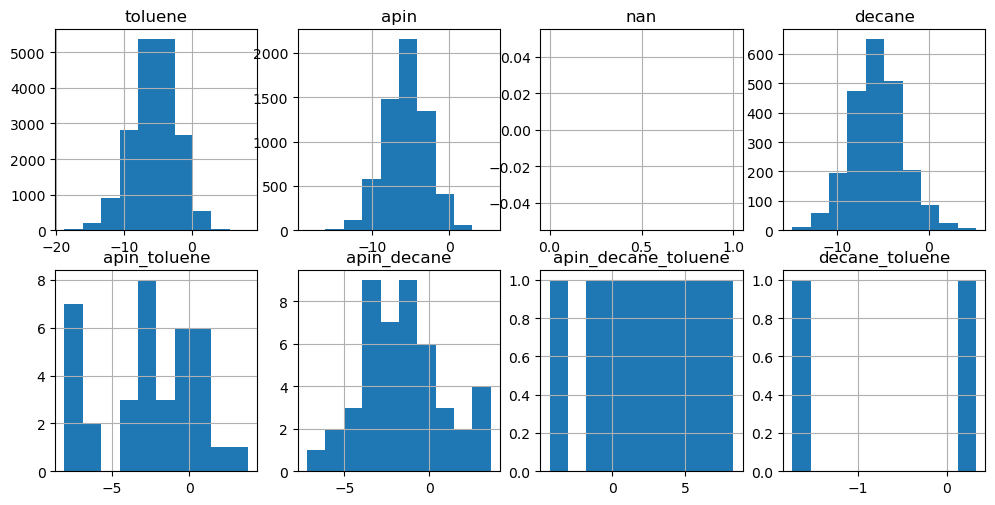

In [93]:
plt.figure(figsize=(12, 12))
uniq_parent = df['parentspecies'].unique()
for i, p in enumerate(uniq_parent):
    plt.subplot(4,4, i+1)
    plt.title(p)
    df[df['parentspecies'] == p]['log_pSat_Pa'].hist()

In [ ]:
def transform_gbr(orig_df):
    df = orig_df.copy()
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Add meaningful features
    df['AtomFraction'] = (df['NumOfC'] + df['NumOfO'] + df['NumOfN']) / df['NumOfAtoms']
    df['Polarity'] = df['NumHBondDonors'] / df['MW']
    df['HBondDensity'] = df['NumHBondDonors'] / df['NumOfAtoms']
    df['GroupDensity_CarboxylicAcid'] = df['carboxylic acid'] / df['MW']
    df['Unsaturation'] = df['C=C (non-aromatic)'] + df['C=C-C=O in non-aromatic ring']
    df['ConfigurationalComplexity'] = df['NumOfConf'] / df['MW']

    # df['C:O_ratio'] = df['NumOfC'] / df['NumOfO']
    # df['C:N_ratio'] = df['NumOfC'] / df['NumOfN']
    # df['Percent_C'] = (df['NumOfC'] / df['NumOfAtoms'])
    # df['Percent_O'] = (df['NumOfO'] / df['NumOfAtoms'])
    # df['Percent_N'] = (df['NumOfN'] / df['NumOfAtoms'])
    # df['HBD_fraction'] = df['NumHBondDonors'] / df['NumOfAtoms']
    # df['FractionOfConfsUsed'] = df['NumOfConfUsed'] / df['NumOfConf']
    # df['Has_Conjugated_System'] = np.where((df['C=C-C=O in non-aromatic ring'] > 0) | (df['C=C (non-aromatic)'] > 0), 1, 0)

    df['NumOfConf'] = np.log(df['NumOfConf'])
    # X_train_gbr['NumOfConfUsed'] = (X_train_gbr['NumOfConfUsed'] == 40).astype(int)
    drop_cols = [
        # 'NumOfC',
        # 'NumOfO',
        # 'NumOfN',
        # 'NumOfAtoms',
        # 'NumHBondDonors',
        # 'carboxylic acid',
        # 'MW',
        # 'C=C-C=O in non-aromatic ring',
        # 'C=C (non-aromatic)',
        # 'NumOfConf',
        # 'NumOfConfUsed',
        'parentspecies',
    ]
    df = df.drop(columns=drop_cols, axis=1)

    return df


trasformed_df = transform_gbr(df)

df.columns

Index(['ID', 'log_pSat_Pa', 'MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
       'NumHBondDonors', 'NumOfConf', 'NumOfConfUsed', 'parentspecies',
       'C=C (non-aromatic)', 'C=C-C=O in non-aromatic ring',
       'hydroxyl (alkyl)', 'aldehyde', 'ketone', 'carboxylic acid', 'ester',
       'ether (alicyclic)', 'nitrate', 'nitro', 'aromatic hydroxyl',
       'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
       'carbonylperoxyacid', 'nitroester', 'NumOfORatio', 'NumOfNRatio',
       'NumHBondDonorsRatio'],
      dtype='object')

In [6]:
df[['NumOfAtoms', 'NumOfO', 'NumOfN', 'NumHBondDonors']].describe()

,NumOfAtoms,NumOfO,NumOfN,NumHBondDonors
count,26637.000000,26637.000000,26637.000000,26637.000000
mean,26.251567,9.937042,1.063558,2.201637
std,5.229818,2.485167,0.710745,1.021029
min,4.000000,0.000000,0.000000,0.000000
25%,23.000000,8.000000,1.000000,2.000000
50%,26.000000,10.000000,1.000000,2.000000
75%,30.000000,12.000000,2.000000,3.000000
max,41.000000,17.000000,2.000000,6.000000


count    26637.000000
mean        -5.516747
std          3.120191
min        -18.822563
25%         -7.515147
50%         -5.450577
75%         -3.429192
max          8.390642
Name: log_pSat_Pa, dtype: float64

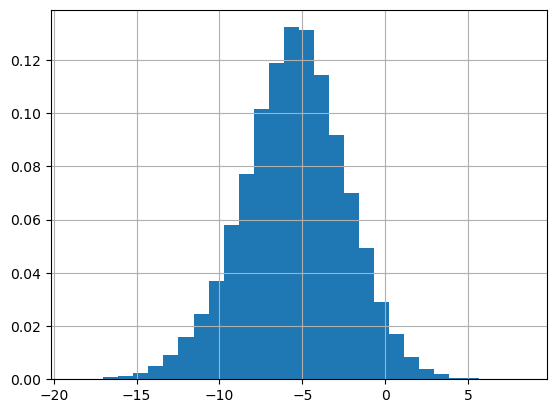

In [22]:
df['log_pSat_Pa'].hist(density=True, bins=30)
df['log_pSat_Pa'].describe()

In [84]:
def evaluate_model(model, X_train, y_train, random_state=42):
    ### Train loss
    y_train_pred = model.predict(X_train)
    train_loss = mean_squared_error(y_train, y_train_pred)

    ### 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    mse_scorer = make_scorer(mean_squared_error)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mse_scorer)
    cv_loss_mean = cv_scores.mean()

    r2_train = r2_score(y_train, y_train_pred)
    r2_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2').mean()

    print('Train loss:', train_loss)
    print('CV loss mean:', cv_loss_mean)
    print('Train R^2:', r2_train)
    print('CV R^2:', r2_cv)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3, 1)
    df['log_pSat_Pa'].hist(density=True, bins=30)
    plt.subplot(1,3, 2)
    plt.hist(y_train_pred, density=True, bins=30)
    plt.subplot(1,3, 3)
    # plt.plot(y_train_pred - df['log_pSat_Pa'])

df['parentspecies'].unique()

array(['toluene', 'apin', nan, 'decane', 'apin_toluene', 'apin_decane',
       'apin_decane_toluene', 'decane_toluene'], dtype=object)

In [ ]:
def meaningful_features(df_orig):
    df = df_orig.copy()
    # df['NumOfORatio'] = df['NumOfO'] /  df['NumOfAtoms'].values
    # df['NumOfNRatio'] = df['NumOfN'] /  df['NumOfAtoms'].values
    # df['NumOfCRatio'] = df['NumOfC'] /  df['NumOfAtoms'].values

    epsilon = 1e-5

    df['AtomFraction'] = (df['NumOfC'] + df['NumOfO'] + df['NumOfN']) / df['NumOfAtoms']
    df['Polarity'] = df['NumHBondDonors'] / df['MW']
    df['HBondDensity'] = df['NumHBondDonors'] / df['NumOfAtoms']
    df['GroupDensity_CarboxylicAcid'] = df['carboxylic acid'] / df['MW']
    df['Unsaturation'] = df['C=C (non-aromatic)'] + df['C=C-C=O in non-aromatic ring']
    df['ConfigurationalComplexity'] = df['NumOfConf'] / df['MW']

    # df['aldehydeRatio'] = np.log(df['aldehyde'] / df['MW'] + epsilon)
    # df['ketoneRatio'] = np.log(df['ketone'] / df['MW'] + epsilon)
    # df['carboxylic acidRatio'] = np.log(df['carboxylic acid'] / df['MW'] + epsilon)
    # df['esterRatio'] = np.log(df['ester'] / df['MW'] + epsilon)
    # df['ether (alicyclic)Ratio'] =np.log( df['ether (alicyclic)'] / df['MW'] + epsilon)
    # df['nitrateRatio'] = np.log(df['nitrate'] / df['MW'] + epsilon)
    # df['nitroRatio'] = np.log(df['nitro'] / df['MW'] + epsilon)
    # df['aromatic hydroxylRatio'] = np.log(df['aromatic hydroxyl'] / df['MW'] + epsilon)
    # df['peroxideRatio'] = np.log(df['peroxide'] / df['MW'] + epsilon)
    # df['nitroesterRatio'] = np.log(df['nitroester'] / df['MW'] + epsilon)
    # df['hydroxyl (alkyl)Ratio'] = np.log(df['hydroxyl (alkyl)'] / df['MW'] + epsilon)
    # df['carbonylperoxynitrateRatio'] = np.log(df['carbonylperoxynitrate'] / df['MW'] + epsilon)
    # df['hydroperoxideRatio'] = np.log(df['hydroperoxide'] / df['MW'] + epsilon)
    # df['carbonylperoxyacidRatio'] = np.log(df['carbonylperoxyacid'] / df['MW'] + epsilon)
        

    df['apin'] = (df['parentspecies'] == 'toluene' | df['parentspecies'] == 'apin_toluene' | df['parentspecies'] == 'apin_decane' |  df['parentspecies'] == 'apin_decane_toluene').values.astype(int) 
    df['decane'] = (df['parentspecies'] == 'toluene' | df['parentspecies'] == 'apin_decane' | df['parentspecies'] == 'decane_toluene' |  df['parentspecies'] == 'apin_decane_toluene').values.astype(int) 
    df['toluene'] = (df['parentspecies'] == 'toluene' | df['parentspecies'] == 'apin_toluene' | df['parentspecies'] == 'decane_toluene' |  df['parentspecies'] == 'apin_decane_toluene').values.astype(int) 

    df['NumOfConf'] = np.log(df['NumOfConf'])


    df = df.drop(columns=[
        # 'MW',
        # 'NumOfAtoms',
        # 'NumOfC',
        # 'NumOfO',
        # 'NumOfN',
        # 'NumHBondDonors',
        # 'NumOfConf',
        # 'NumOfConfUsed',
        # 'C=C (non-aromatic)',
        # 'C=C-C=O in non-aromatic ring',
        # 'hydroxyl (alkyl)',
        # 'aldehyde',
        # 'ketone',
        # 'carboxylic acid',
        # 'ester',
        # 'ether (alicyclic)',
        # 'nitrate',
        # 'nitro',
        # 'aromatic hydroxyl',
        # 'carbonylperoxynitrate',
        # 'peroxide',
        # 'hydroperoxide',
        # 'carbonylperoxyacid',
        # 'nitroester'
        'parentspecies',
        ], axis=1)

    return df


In [105]:
X_train, y_train = df.drop(columns=['log_pSat_Pa', 'ID']), df['log_pSat_Pa']
X_train_gbr = meaningful_features(X_train)


TypeError: Cannot perform 'ror_' with a dtyped [object] array and scalar of type [bool]

Train loss: 2.7636463658646897
CV loss mean: 2.771260991261187
Train R^2: 0.7156462912014305
CV R^2: 0.7147945906845059


,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C=C (non-aromatic),C=C-C=O in non-aromatic ring,...,HBondDensity,GroupDensity_CarboxylicAcid,Unsaturation,ConfigurationalComplexity,toluene,apin,apin_toluene,apin_decane,apin_decane_toluene,decane_toluene
0,224.016832,23,6,9,0,4,6.184149,40.0,0,0,...,0.173913,0.004464,0,2.165016,1,0,0,0,0,0
1,310.064845,35,9,10,2,1,5.463832,40.0,0,0,...,0.028571,0.000000,0,0.761131,0,1,0,0,0,0
2,368.033938,37,10,13,2,1,5.730100,40.0,0,0,...,0.027027,0.000000,0,0.836879,0,1,0,0,0,0
3,299.012475,29,7,12,1,4,6.645091,3.0,0,0,...,0.137931,0.000000,0,2.571799,1,0,0,0,0,0
4,202.011353,20,7,7,0,1,4.343805,32.0,0,0,...,0.050000,0.000000,0,0.381167,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26632,221.017166,22,6,8,1,1,3.850148,37.0,0,0,...,0.045455,0.000000,0,0.212653,1,0,0,0,0,0
26633,222.001182,21,6,9,0,3,5.777652,12.0,0,0,...,0.142857,0.009009,0,1.454947,1,0,0,0,0,0
26634,287.012475,28,6,12,1,4,5.891644,11.0,0,0,...,0.142857,0.000000,0,1.261269,1,0,0,0,0,0
26635,284.996825,26,6,12,1,3,5.774552,35.0,0,0,...,0.115385,0.000000,0,1.129837,1,0,0,0,0,0


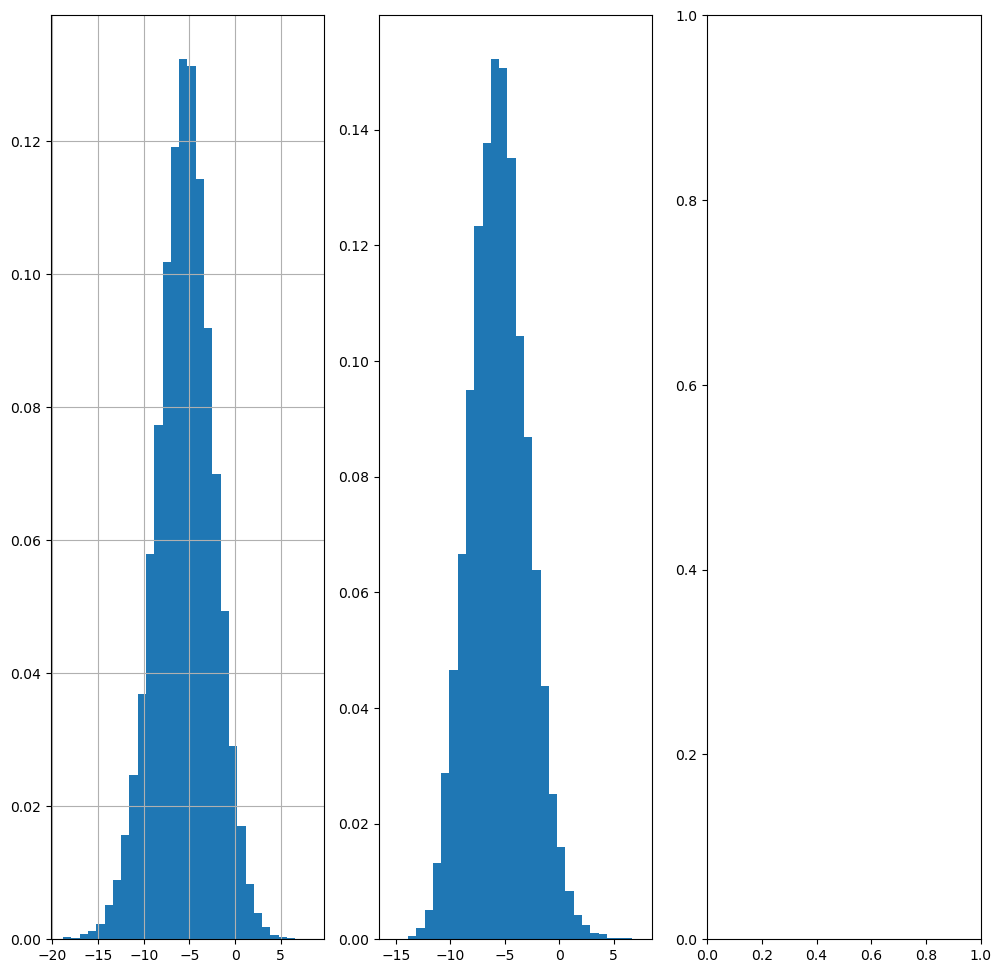

In [100]:

mask = df['parentspecies'].isin([
    'toluene',
    'apin',
    'decane',
    'apin_decane_toluene',
    'decane_toluene',
])

model = LinearRegression()
model.fit(X_train_gbr[mask], y_train[mask])

evaluate_model(model, X_train_gbr[mask], y_train[mask])
X_train_gbr[mask]

Train loss: 2.549291615691281
CV loss mean: 2.577785073008737
Train R^2: 0.7381374697501131
CV R^2: 0.7350595519894354


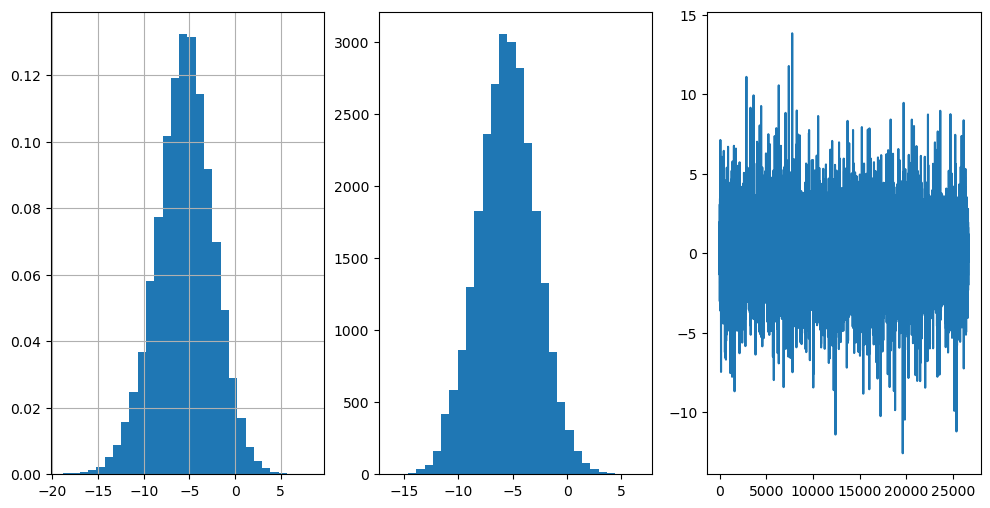

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

poly = PolynomialFeatures(2, interaction_only=True).fit(X_train_gbr)
X_train_poly = poly.transform(X_train_gbr)

pca = PCA(n_components=120, svd_solver='arpack').fit(X_train_poly)
X_train_pca = pca.transform(X_train_poly)

model = LinearRegression()
model.fit(X_train_pca, y_train)

evaluate_model(model, X_train_pca, y_train)


In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

# a* = (a - mean(a)) / std(a)

model = make_pipeline(StandardScaler(), SVR(C=0.5, epsilon=0.3, kernel='rbf',))
model.fit(X_train_gbr, y_train)

evaluate_model(model, X_train_gbr, y_train)

Train loss: 2.469433293564631
CV loss mean: 2.898922177032064
Train R^2: 0.7463404945295771
CV R^2: 0.7020233151871067


Train loss: 2.089031299921942
CV loss mean: 2.5013919285624175
Train R^2: 0.785415282189899
CV R^2: 0.7428850514151051


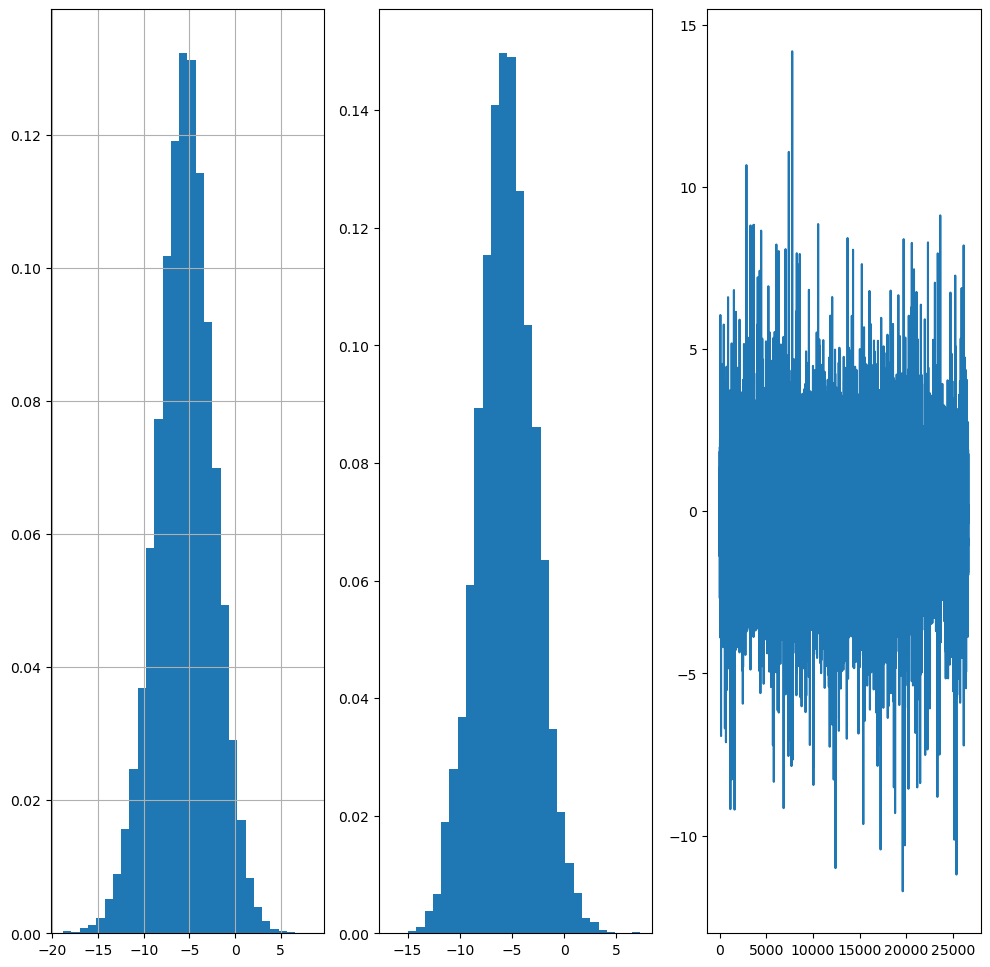

In [36]:
gbr_params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss": "huber",
    "random_state": 42,
    # "subsample": 0.6,
}
    
model = GradientBoostingRegressor(**gbr_params)
model.fit(X_train_gbr, y_train)

evaluate_model(model, X_train_gbr, y_train)


In [ ]:
test_ids = df_test['ID']
X_test = meaningful_features(df_test).drop(columns=['ID'], axis=1)


df_test['log_pSat_Pa'] = model.predict(X_test)
df_test[['ID', 'log_pSat_Pa']].to_csv('../submission/submission.csv', index=False)